# Psycholinguistic classifier

In [106]:
%load_ext autoreload
%autoreload 2
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

from matplotlib import pyplot as plt
%matplotlib inline  

from data import Data

import pandas as pd

import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = pd.read_csv('utils/Psycholinguistic_Features.txt', sep='\t')
df_mean = df.mean(axis=0)
training_data = ['datasets/english/News_Train.tsv',
                 'datasets/english/WikiNews_Train.tsv',
                 'datasets/english/Wikipedia_Train.tsv',
                ]
dev_data = ['datasets/english/News_Dev.tsv',
            'datasets/english/WikiNews_Dev.tsv',
            'datasets/english/Wikipedia_Dev.tsv'
           ]

In [3]:
data_train = Data()
data_train.load_data(training_data)

data_dev = Data()
data_dev.load_data(dev_data)

In [97]:
def get_psicolinguistics(df, df_mean, words):
    psicos = []
    for word in words:
        psico = {'Familiarity': 0, 'Age_of_Acquisition':0,
                 'Concreteness':0,'Imagery': 0}
        infos = df[df.Word == word]
        if not infos.empty:
            for key in psico.keys():
                psico[key] += infos[key].values[0]
        else:
            for key in psico.keys():
                psico[key] += df_mean[key]
        psicos.append(pd.Series(psico, index=psico.keys()))
    return pd.DataFrame(psicos).mean()

def get_features(df, df_mean, instances):
    x = pd.DataFrame()
    for instance in instances:
        tokens = [instance.tokens[i] for i in instance.target]
        x = x.append(get_psicolinguistics(df,
                                          df_mean,
                                          tokens), ignore_index=True)
    return x

def print_roc(pred, y, message='Roc curve'):
    fpr, tpr, _ = roc_curve(y.ravel(), pred.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(message)
    plt.legend(loc="lower right")
    plt.show()

In [55]:
x_train = get_features(df, df_mean, data_train.instances)
y_train = np.array([instance.label[0] for instance in data_train.instances])

x_dev = get_features(df, df_mean, data_dev.instances)
y_dev = np.array([instance.label[0] for instance in data_dev.instances])

-----
# Predicting

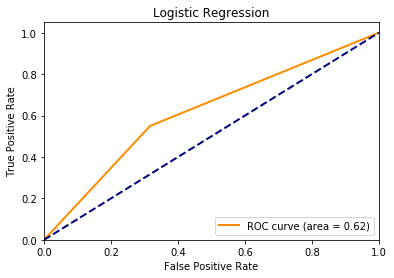

In [102]:
reg = LogisticRegression()
reg.fit(x_train, y_train)
pred = reg.predict(x_dev)
print_roc(pred, y_dev, 'Logistic Regression')

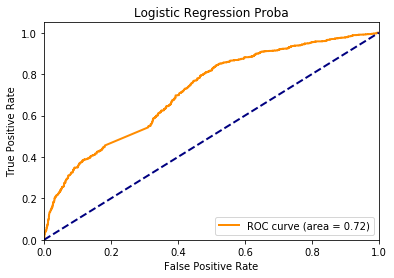

In [104]:
reg = LogisticRegression()
reg.fit(x_train, y_train)
pred = reg.predict_proba(x_dev)[:, 1:]
print_roc(pred, y_dev, 'Logistic Regression Proba')

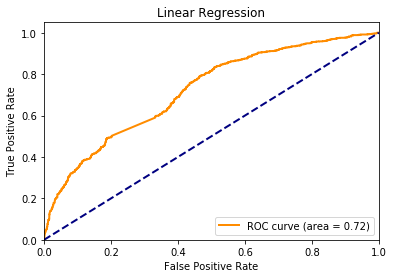

In [105]:
reg = LinearRegression()
reg.fit(x_train, y_train)
pred = reg.predict(x_dev)
print_roc(pred, y_dev, 'Linear Regression')

In [ ]:
tree = DecisionTreeClassifier()
tree.fit(x_train, y_train)
pred = tree.predict(x_dev)
print_roc(pred, y_dev, 'Decision Tree')

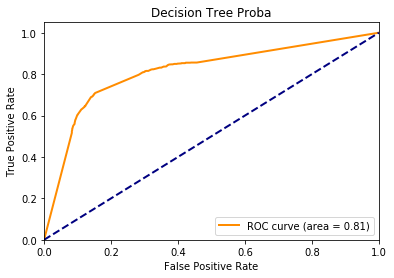

In [114]:
tree = DecisionTreeClassifier()
tree.fit(x_train, y_train)
pred = tree.predict_proba(x_dev)[:, 1:]
print_roc(pred, y_dev, 'Decision Tree Proba')

-----
# Tests

* target words not in psycholinguistic_features

In [110]:
count = 0
errors = []
for instance in data_train.instances:
    for target in instance.target:
        try:
            if len(df[df.Word == instance.tokens[target]].index) == 0:
                count += 1
                errors.append(instance.tokens[target])
        except:
            print(target, instance.target_chars, instance.tokens)
print('%d / %d' % (count, len(data_train.instances)))
print(list(set(errors)))

4014 / 27299
['', 'kabul', 'crackdown', 'goldenbridge', 'targeted', 'mla', 'amygdala', 'brevard', 'blek', 'teammate', 'jarvis', 'radars', 'cooperation', 'cernan', 'thumbs-up', 'stanković', 'gardner', 'luhman', 'bos', 'islamist', 'refinance', 'lockdown', 'tawam', 'kong', 'atropos', 'primetime', 'lt', 'bbc', 'dibenzenechromium', 'dvd', 'césar', 'organometallic', 'pompeii', 'asia', 'samsung', 'six-hour', 'nestmates', 'oriente', 'nasser', 'al-burnhanieh', 'london-based', 'iczn', 'perkasie', 'caspicara', 'maakond', 'itunes', 'pushkin', 'schengen', 'scm', 'brp', 'ibm', 'obamacare', 'moesian', 'pupates', 'kcvo', 'signings', 'premiered', 'kremlin-dominated', 'confusingly', 'choe', 'murad', 'karam', 'ex-soviet', 'primeiro', 'disabled/handicapped', 'fernando', 'worldwide', 'noorughli', 'doskozil', 'bosnia', 'mimar', 'eyewitnesses', 'kcb', 'timeline', 'psni', 'keita', 'rosenkavalier', '“', 'utc', 'hudson', 'gliese', 'favorites', 'shalygina', 'jaeg', 'six-point', 'thespis', 'temer', 'magherafelt',